# Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd

np.random.seed(40)  # Set the seed for reproducibility

# Check if the original directory is already saved in a variable
if 'original_directory' not in globals():
    # Save the original working directory the first time
    original_directory = os.getcwd()

# Change back to the original directory whenever the cell is executed
os.chdir(original_directory)

# Go to mother directory
os.chdir("../")

# Verify the current working directory
print("Working directory set to:", os.getcwd())

sys.path.append(os.path.abspath(os.getcwd()))


Working directory set to: c:\Users\Biebert\OneDrive - Universität St.Gallen\Dokumente\OneDrive Dokumente\02_Bildung\01_BVWL Bachelor\01_Kurse\07_Thesis\Code\Portfolio_Optimization_DDPG


In [ ]:
from data_scripts import generate_data as gd
from data_scripts import plotting as pl
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']
num_simulation_episodes = 500
num_simulation_days = 750

train = pd.read_csv("data/train_data.csv", index_col=0)
test = pd.read_csv("data/test_data.csv", index_col=0)

for stock in train:
    print(f"Simulating data for {stock}...")
    sim_df_train, sim_df_test = gd.simulate_many_episodes(train[stock], 1, 1, dist='normal', num_days = num_simulation_days, 
                                                        num_simulation_episodes = num_simulation_episodes, test_size = 0.2, 
                                                        initial_price = 100, load_model = False, save = True)

                                                        
    print(f"Simulated data for {stock} generated successfully!")
print("All data simulated successfully!")

In [9]:
pl.plot_simulations(sim_df_train, title="Training Simulations")
pl.plot_simulations(sim_df_test, title="Testing Simulations")

In [2]:
from data_scripts import generate_data as gd
from data_scripts import plotting as pl
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']

# Load simulation data for the selected stocks
stock_data_dict = gd.load_simulation_data(tickers)

# Get the combined training simulation data for the selected stocks
combined_train_data = gd.get_combined_simulation(stock_data_dict, simulation_index=0, set_type='train')


# Assuming combined_train_data is a NumPy array or a DataFrame
num_days_train, num_ep_train = data = stock_data_dict[tickers[0]]['train'].shape
num_days_test, num_ep_test = data = stock_data_dict[tickers[0]]['test'].shape


In [ ]:
import random
import numpy as np
from trading_envs.trading_env import TradingEnv
from models.ddpg_agent import Agent
from tqdm import tqdm

# Initialize variables
train_simulations = 500
test_simulations = num_ep_test
train_days = num_days_train
test_days = num_days_test

num_episodes = train_simulations
max_steps_per_episode = train_days 

reward_function = 'portfolio_value_small'


# Initialize the environment and the agent
train_simulation_data = gd.get_combined_simulation(stock_data_dict, simulation_index=0, set_type='train')
env = TradingEnv(stock_data=train_simulation_data)
agent = Agent(alpha=0.0001, beta=0.001, input_dims=[env.observation_space.shape[0]], 
                tau=0.001, env=env, batch_size=64, layer1_size=400, layer2_size=300, 
                n_actions=env.action_space.shape[0])

# Initialize DataFrames
episode_scores_df = pd.DataFrame(columns=['Episode', 'Score'])
wealth_df = pd.DataFrame(columns=['Episode', 'TimeStep', 'Wealth'])
actions_columns = ['Episode', 'TimeStep'] + [f'Action_{i}' for i in range(env.action_space.shape[0])]
actions_df = pd.DataFrame(columns=actions_columns)
states_columns = ['Episode', 'TimeStep'] + [f'State_{i}' for i in range(env.observation_space.shape[0])]
states_df = pd.DataFrame(columns=states_columns)
rewards_df = pd.DataFrame(columns=['Episode', 'TimeStep', 'Reward'])

# Training loop only one time
for episode in tqdm(range(num_episodes), desc="Training Progress"):
    print(f'Episode: {episode}')
    episode_wealth = []
    episode_actions = []
    episode_states = []
    episode_rewards = []

    # Reset environment and variables
    state, _ = env.reset()
    done = False
    score = 0
    time_step = 0

    while not done:
        action = agent.choose_action(state)
        state_, reward, done, _, _ = env.step(action)
        agent.remember(state, action, reward, state_, done)
        agent.learn()
        score += reward

        # Collect data
        episode_wealth.append({
            'Episode': episode, 
            'TimeStep': time_step, 
            'Wealth': env.get_portfolio_value()
        })

        action_record = {'Episode': episode, 'TimeStep': time_step}
        action_record.update({f'Action_{i}': a for i, a in enumerate(action)})
        episode_actions.append(action_record)

        state_record = {'Episode': episode, 'TimeStep': time_step}
        state_record.update({f'State_{i}': s for i, s in enumerate(state)})
        episode_states.append(state_record)

        episode_rewards.append({
            'Episode': episode, 
            'TimeStep': time_step, 
            'Reward': reward
        })

        state = state_
        time_step += 1

    # Append episode data to DataFrames
    episode_scores_df = pd.concat([episode_scores_df, pd.DataFrame([{'Episode': episode, 'Score': score}])], ignore_index=True)
    wealth_df = pd.concat([wealth_df, pd.DataFrame(episode_wealth)], ignore_index=True)
    actions_df = pd.concat([actions_df, pd.DataFrame(episode_actions)], ignore_index=True)
    states_df = pd.concat([states_df, pd.DataFrame(episode_states)], ignore_index=True)
    rewards_df = pd.concat([rewards_df, pd.DataFrame(episode_rewards)], ignore_index=True)


agent.save_models(suffix='_'+reward_function +'_1')

episode_scores_df.to_csv(f'data/episode_scores_{reward_function}.csv', index=False)
wealth_df.to_csv(f'data/wealth_over_time_{reward_function}.csv', index=False)
actions_df.to_csv(f'data/actions_taken_{reward_function}.csv', index=False)
states_df.to_csv(f'data/states_observed_{reward_function}.csv', index=False)
rewards_df.to_csv(f'data/rewards_received_{reward_function}.csv', index=False)


import datetime

def generate_time():
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{timestamp}"

time = generate_time()

agent.save_models(suffix=f'_{time}_{reward_function}')

# Save with unique filename
episode_scores_df.to_csv(f'data_save/episode_scores_{time}_{reward_function}.csv', index=False)
wealth_df.to_csv(f'data_save/wealth_over_time_{time}_{reward_function}.csv', index=False)
actions_df.to_csv(f'data_save/actions_taken_{time}_{reward_function}.csv', index=False)
states_df.to_csv(f'data_save/states_observed_{time}_{reward_function}.csv', index=False)
rewards_df.to_csv(f'data_save/rewards_received_{time}_{reward_function}.csv', index=False)



In [ ]:
#20241023_021514 Lagre network with portfolio value: Does nto seem to converge

In [ ]:
# Load simulation data for the selected stocks
stock_data_dict = gd.load_simulation_data(tickers)



In [26]:
from tqdm import tqdm
import numpy as np
from data_scripts import generate_data as gd
from data_scripts import plotting as pl

# Initialize an empty list to store the surplus values for each simulation
surplus = []
markets = []
agents = []

# Read csv data once
agent_wealth = pd.read_csv('data_save/wealth_over_time_20241023_021514_portfolio_value.csv')

# Loop over each simulation index
for i in tqdm(range(400), desc="Simulations Progress"):
    # Filter agent wealth data for the current episode once
    agent_wealth_e = agent_wealth[agent_wealth['Episode'] == i].set_index('TimeStep')

    wealth = 1000  # Initial wealth
    wealth_per_asset = np.full(5, wealth / 5)  # Equal wealth per asset (vectorized)

    # Get the combined training simulation data for the selected stocks
    combined_train_data = gd.get_combined_simulation(stock_data_dict, simulation_index=i, set_type='train')
    price_previous_end = np.array(combined_train_data[0])  # Initial prices

    # Preallocate the portfolio surplus list
    portfolio_surplus = np.empty(len(combined_train_data) - 1)
    market = np.empty(len(combined_train_data) - 1)
    agent = np.empty(len(combined_train_data) - 1)

    # Iterate over the time steps
    for n in range(1, len(combined_train_data)):
        # Retrieve agent wealth data for the current timestep
        agent_wealth_day = agent_wealth_e.loc[n-1, 'Wealth']

        current_prices_end = np.array(combined_train_data[n])  # Current prices
        price_relative = current_prices_end / price_previous_end  # Relative price changes

        # Update wealth per asset (element-wise multiplication)
        wealth_per_asset *= price_relative

        # Update total portfolio wealth
        wealth = wealth_per_asset.sum()

        # Calculate wealth difference (agent wealth - calculated wealth)
        wealth_diff = agent_wealth_day - wealth

        # Store the wealth difference
        portfolio_surplus[n-1] = np.round(wealth_diff, 2)
        market[n-1] = np.round(wealth, 2)  # Round market value to 2 decimal places
        agent[n-1] = np.round(agent_wealth_day, 2)

        # Update previous prices for the next iteration
        price_previous_end = current_prices_end

    # Append the portfolio surplus for this simulation to the overall surplus list
    surplus.append(portfolio_surplus)
    markets.append(market)
    agents.append(agent)
    

# Now 'surplus' contains the wealth differences for all simulations and time steps.


Simulations Progress: 100%|██████████| 400/400 [00:28<00:00, 13.99it/s]


In [27]:
import plotly.graph_objects as go
import numpy as np

# Create a figure
fig = go.Figure()

# Set up colors ranging from light to dark blue
num_episodes = len(surplus)
color_gradient = np.linspace(0.2, 1, num_episodes)  # Generates values from 0.2 (light blue) to 1 (dark blue)

# Plot each episode's surplus data with progressively darker blue
for i in tqdm(range(num_episodes), desc="Simulations Progress"):
    fig.add_trace(go.Scatter(
        y=surplus[i],
        mode='lines',
        name=f'Episode {i+1}',
        line=dict(color=f'rgba(0, 0, 255, {color_gradient[i]})', width=2)  # Increasingly dark blue
    ))

# Update layout to make it interactive and clear
fig.update_layout(
    title="Surplus Over Time for Each Episode",
    xaxis_title="Time Step",
    yaxis_title="Surplus",
    hovermode="x unified",  # Shows all episode values at a given timestep
    showlegend=True
)

# Show the interactive plot
fig.show()


Simulations Progress: 100%|██████████| 400/400 [00:00<00:00, 951.95it/s] 


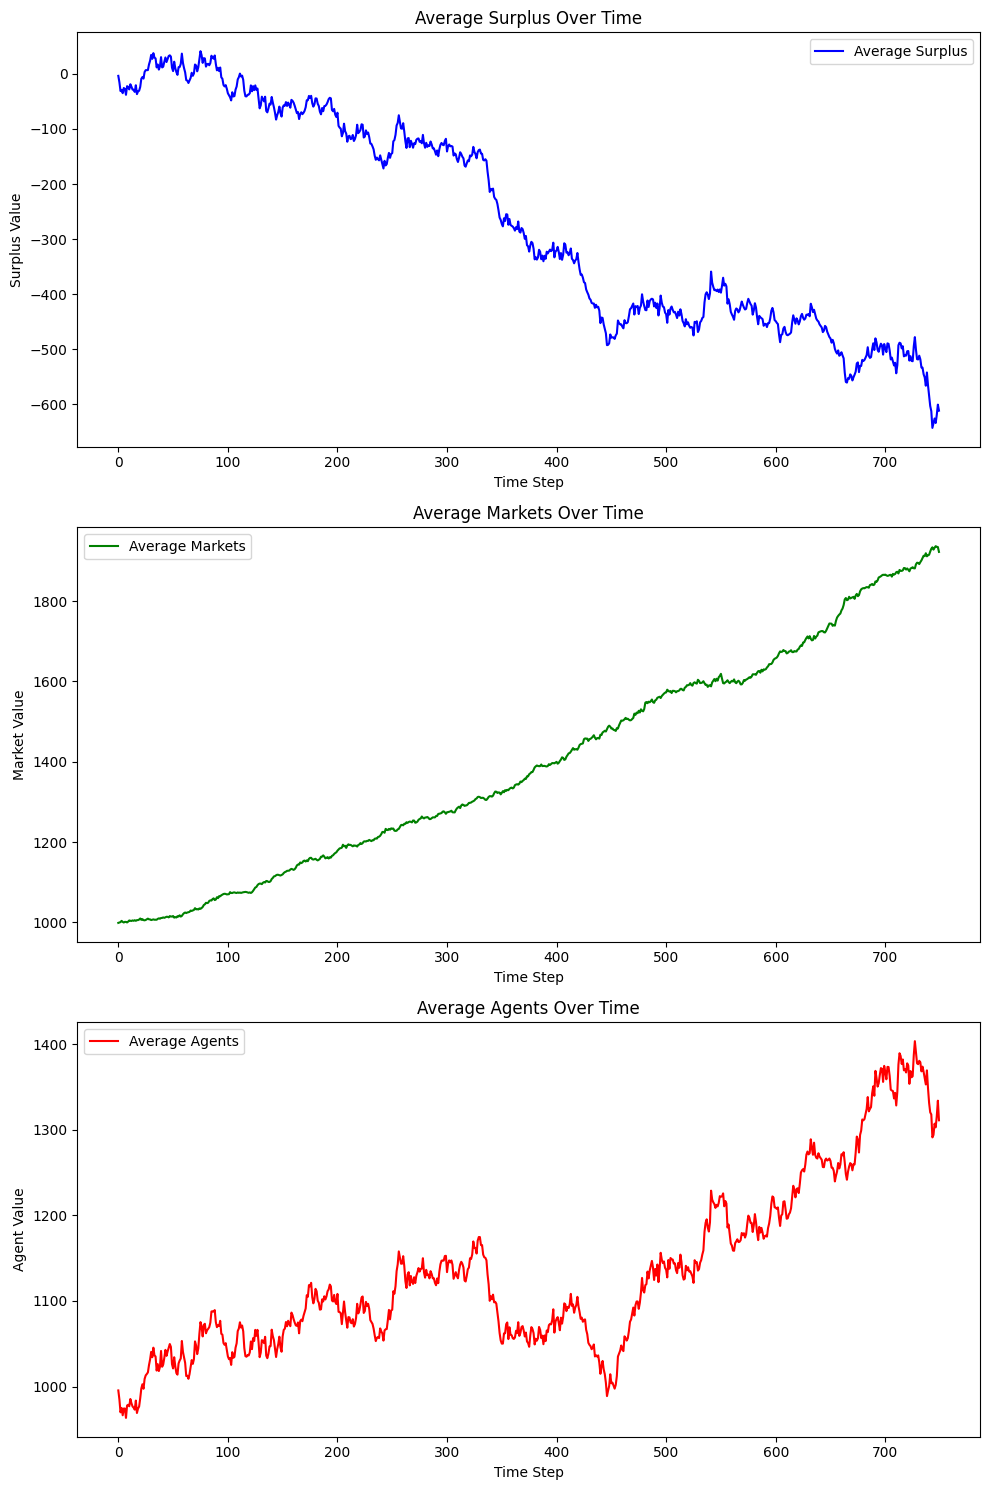

In [28]:
import matplotlib.pyplot as plt

# Average list of all lists from the last 30
average_surplus = np.mean(surplus[-30:], axis=0)
average_markets = np.mean(markets[-30:], axis=0)
average_agents = np.mean(agents[-30:], axis=0)
# Plot

# Create subplots to show all three lists in separate plots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the average_surplus
axes[0].plot(average_surplus, label='Average Surplus', color='blue')
axes[0].set_title('Average Surplus Over Time')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Surplus Value')
axes[0].legend()

# Plot the average_markets
axes[1].plot(average_markets, label='Average Markets', color='green')
axes[1].set_title('Average Markets Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Market Value')
axes[1].legend()

# Plot the average_agents
axes[2].plot(average_agents, label='Average Agents', color='red')
axes[2].set_title('Average Agents Over Time')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Agent Value')
axes[2].legend()

# Adjust layout to make sure plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

# Test

In [3]:
from data_scripts import generate_data as gd
from data_scripts import plotting as pl
tickers = ['MSFT', 'TGT', 'QCOM', 'MU', 'CAT']

# Load simulation data for the selected stocks
stock_data_dict = gd.load_simulation_data(tickers)

# Get the combined training simulation data for the selected stocks
combined_train_data = gd.get_combined_simulation(stock_data_dict, simulation_index=0, set_type='train')


# Assuming combined_train_data is a NumPy array or a DataFrame
num_days_train, num_ep_train = data = stock_data_dict[tickers[0]]['train'].shape
num_days_test, num_ep_test = data = stock_data_dict[tickers[0]]['test'].shape


In [5]:
import random
import numpy as np
from trading_envs.trading_env import TradingEnv_L
from models.ddpg_agent import Agent
from tqdm import tqdm


# Test on new test data
test_simulations = num_ep_test
test_days = num_days_test
test_simulation_data = gd.get_combined_simulation(stock_data_dict, simulation_index=0, set_type='test')
env_test = TradingEnv_L(stock_data=test_simulation_data)


agent = Agent(alpha=0.0001, beta=0.001, input_dims=[env_test.observation_space.shape[0]], 
                tau=0.001, env=env_test, batch_size=64, layer1_size=400, layer2_size=300, 
                n_actions=env_test.action_space.shape[0])

# Load the trained model
agent.load_models(suffix=f'_20241023_021514_portfolio_value')  # Load the most recent saved model

actions_columns = ['Episode', 'TimeStep'] + [f'Action_{i}' for i in range(env_test.action_space.shape[0])]

# DataFrames to store test results
test_wealth_df = pd.DataFrame(columns=['Episode', 'TimeStep', 'Wealth'])
test_actions_df = pd.DataFrame(columns=actions_columns)
test_rewards_df = pd.DataFrame(columns=['Episode', 'TimeStep', 'Reward'])

# Testing loop
for episode in tqdm(range(test_simulations), desc="Testing Progress"):
    episode_wealth = []
    episode_actions = []
    episode_rewards = []

    # Reset environment and variables
    train_simulation_index = random.choice(range(test_simulations))
    test_simulation_data = gd.get_combined_simulation(stock_data_dict, simulation_index=train_simulation_index, set_type='test')
    env_test = TradingEnv_L(stock_data=test_simulation_data)

    # Reset environment for the test episode
    state, _ = env_test.reset()
    done = False
    time_step = 0

    while not done:
        action = agent.choose_action(state)  # Use the trained agent
        state_, reward, done, _, _ = env_test.step(action)

        # Collect test data
        episode_wealth.append({
            'Episode': episode,
            'TimeStep': time_step,
            'Wealth': env_test.get_portfolio_value()
        })

        action_record = {'Episode': episode, 'TimeStep': time_step}
        action_record.update({f'Action_{i}': a for i, a in enumerate(action)})
        episode_actions.append(action_record)

        episode_rewards.append({
            'Episode': episode,
            'TimeStep': time_step,
            'Reward': reward
        })

        state = state_
        time_step += 1

    # Append episode data to DataFrames
    test_wealth_df = pd.concat([test_wealth_df, pd.DataFrame(episode_wealth)], ignore_index=True)
    test_actions_df = pd.concat([test_actions_df, pd.DataFrame(episode_actions)], ignore_index=True)
    test_rewards_df = pd.concat([test_rewards_df, pd.DataFrame(episode_rewards)], ignore_index=True)


import datetime

def generate_time():
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{timestamp}"

reward_function = 'portfolio_value'

# Save test results
test_time = generate_time()
# test_wealth_df.to_csv(f'data_save/wealth_over_time_test_{test_time}_{reward_function}.csv', index=False)
# test_actions_df.to_csv(f'data_save/actions_taken_test_{test_time}_{reward_function}.csv', index=False)
# test_rewards_df.to_csv(f'data_save/rewards_received_test_{test_time}_{reward_function}.csv', index=False)


... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


Testing Progress: 100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [10]:
from tqdm import tqdm
import numpy as np
from data_scripts import generate_data as gd
from data_scripts import plotting as pl

# Initialize an empty list to store the surplus values for each simulation
surplus = []
markets = []
agents = []

# Read csv data once
agent_wealth = pd.read_csv('data_save/wealth_over_time_test_20241023_113501_portfolio_value.csv')


# Loop over each simulation index
for i in tqdm(range(100), desc="Simulations Progress"):
    # Filter agent wealth data for the current episode once
    agent_wealth_e = agent_wealth[agent_wealth['Episode'] == i].set_index('TimeStep')

    wealth = 800  # Initial wealth
    wealth_per_asset = np.full(5, wealth / 5)  # Equal wealth per asset (vectorized)

    # Get the combined training simulation data for the selected stocks
    combined_train_data = gd.get_combined_simulation(stock_data_dict, simulation_index=i, set_type='test')
    price_previous_end = np.array(combined_train_data[0])  # Initial prices

    # Preallocate the portfolio surplus list
    portfolio_surplus = np.empty(len(combined_train_data) - 1)
    market = np.empty(len(combined_train_data) - 1)
    agent = np.empty(len(combined_train_data) - 1)

    # Iterate over the time steps
    for n in range(1, len(combined_train_data)):
        # Retrieve agent wealth data for the current timestep
        agent_wealth_day = agent_wealth_e.loc[n-1, 'Wealth']

        current_prices_end = np.array(combined_train_data[n])  # Current prices
        price_relative = current_prices_end / price_previous_end  # Relative price changes

        # Update wealth per asset (element-wise multiplication)
        wealth_per_asset *= price_relative

        # Update total portfolio wealth
        wealth = wealth_per_asset.sum() + 200

        # Calculate wealth difference (agent wealth - calculated wealth)
        wealth_diff = agent_wealth_day - wealth

        # Store the wealth difference
        portfolio_surplus[n-1] = np.round(wealth_diff, 2)
        market[n-1] = np.round(wealth, 2)  # Round market value to 2 decimal places
        agent[n-1] = np.round(agent_wealth_day, 2)

        # Update previous prices for the next iteration
        price_previous_end = current_prices_end

    # Append the portfolio surplus for this simulation to the overall surplus list
    surplus.append(portfolio_surplus)
    markets.append(market)
    agents.append(agent)
    

# Now 'surplus' contains the wealth differences for all simulations and time steps.


Simulations Progress: 100%|██████████| 100/100 [00:06<00:00, 15.63it/s]


In [11]:
import plotly.graph_objects as go
import numpy as np

# Create a figure
fig = go.Figure()

# Set up colors ranging from light to dark blue
num_episodes = len(surplus)
color_gradient = np.linspace(0.2, 1, num_episodes)  # Generates values from 0.2 (light blue) to 1 (dark blue)

# Plot each episode's surplus data with progressively darker blue
for i in tqdm(range(num_episodes), desc="Simulations Progress"):
    fig.add_trace(go.Scatter(
        y=surplus[i],
        mode='lines',
        name=f'Episode {i+1}',
        line=dict(color=f'rgba(0, 0, 255, {color_gradient[i]})', width=2)  # Increasingly dark blue
    ))

# Update layout to make it interactive and clear
fig.update_layout(
    title="Surplus Over Time for Each Episode",
    xaxis_title="Time Step",
    yaxis_title="Surplus",
    hovermode="x unified",  # Shows all episode values at a given timestep
    showlegend=True
)

# Show the interactive plot
fig.show()


Simulations Progress:  52%|█████▏    | 52/100 [00:00<00:00, 519.76it/s]

Simulations Progress: 100%|██████████| 100/100 [00:00<00:00, 246.90it/s]


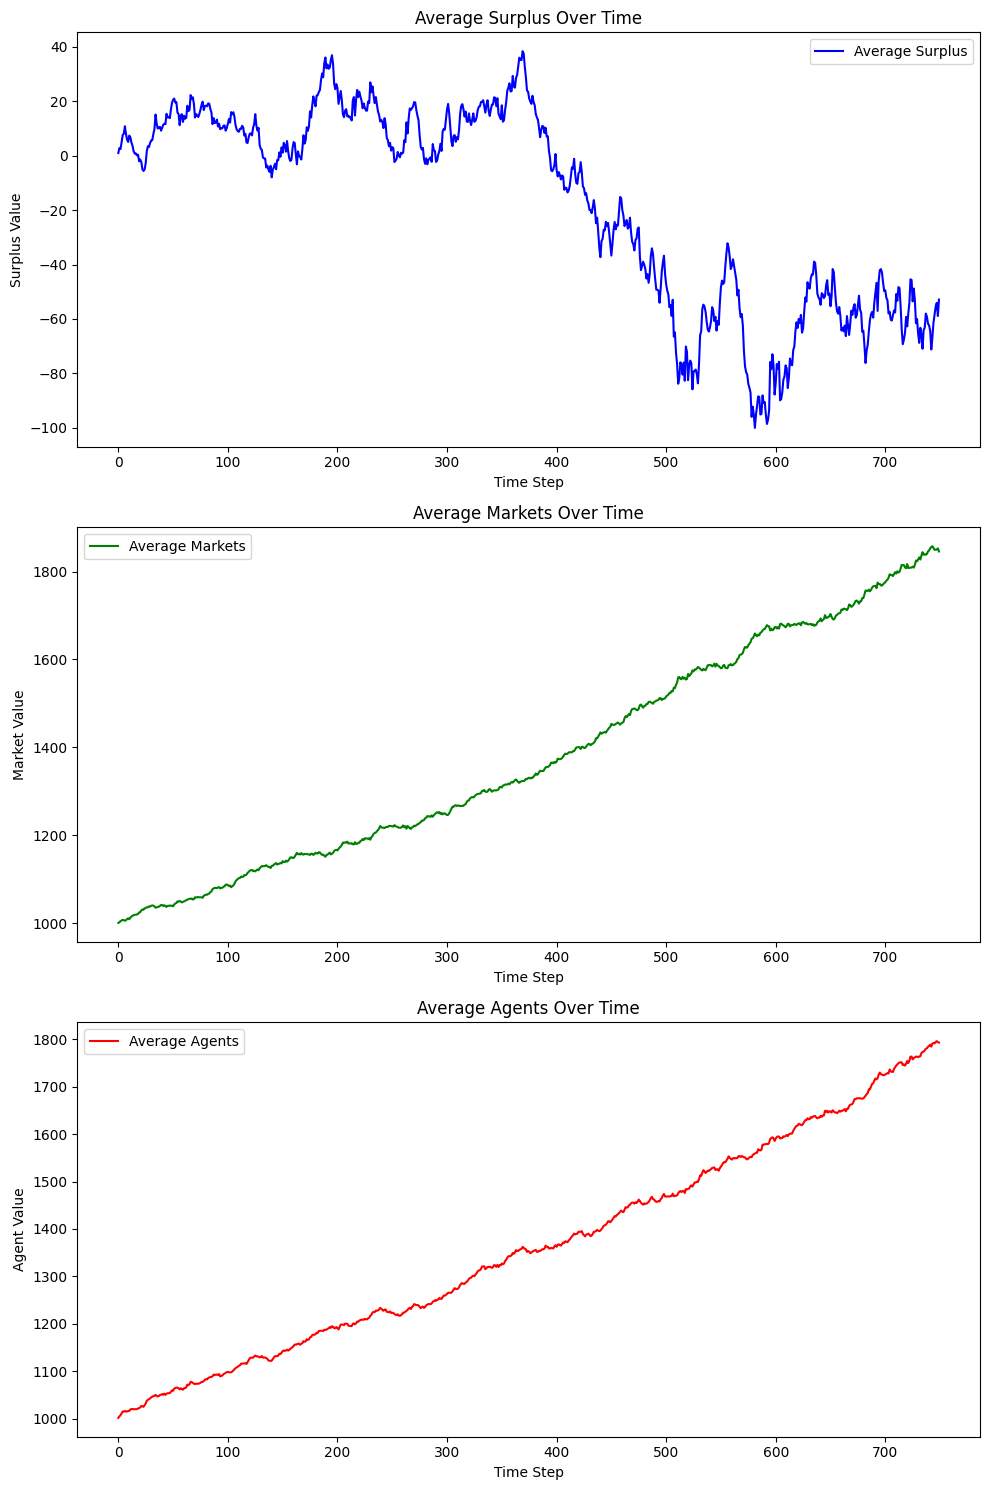

In [8]:
import matplotlib.pyplot as plt

# Average list of all lists from the last 30
average_surplus = np.mean(surplus[-30:], axis=0)
average_markets = np.mean(markets[-30:], axis=0)
average_agents = np.mean(agents[-30:], axis=0)
# Plot

# Create subplots to show all three lists in separate plots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the average_surplus
axes[0].plot(average_surplus, label='Average Surplus', color='blue')
axes[0].set_title('Average Surplus Over Time')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Surplus Value')
axes[0].legend()

# Plot the average_markets
axes[1].plot(average_markets, label='Average Markets', color='green')
axes[1].set_title('Average Markets Over Time')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Market Value')
axes[1].legend()

# Plot the average_agents
axes[2].plot(average_agents, label='Average Agents', color='red')
axes[2].set_title('Average Agents Over Time')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Agent Value')
axes[2].legend()

# Adjust layout to make sure plots don't overlap
plt.tight_layout()

# Show the plot
plt.show()

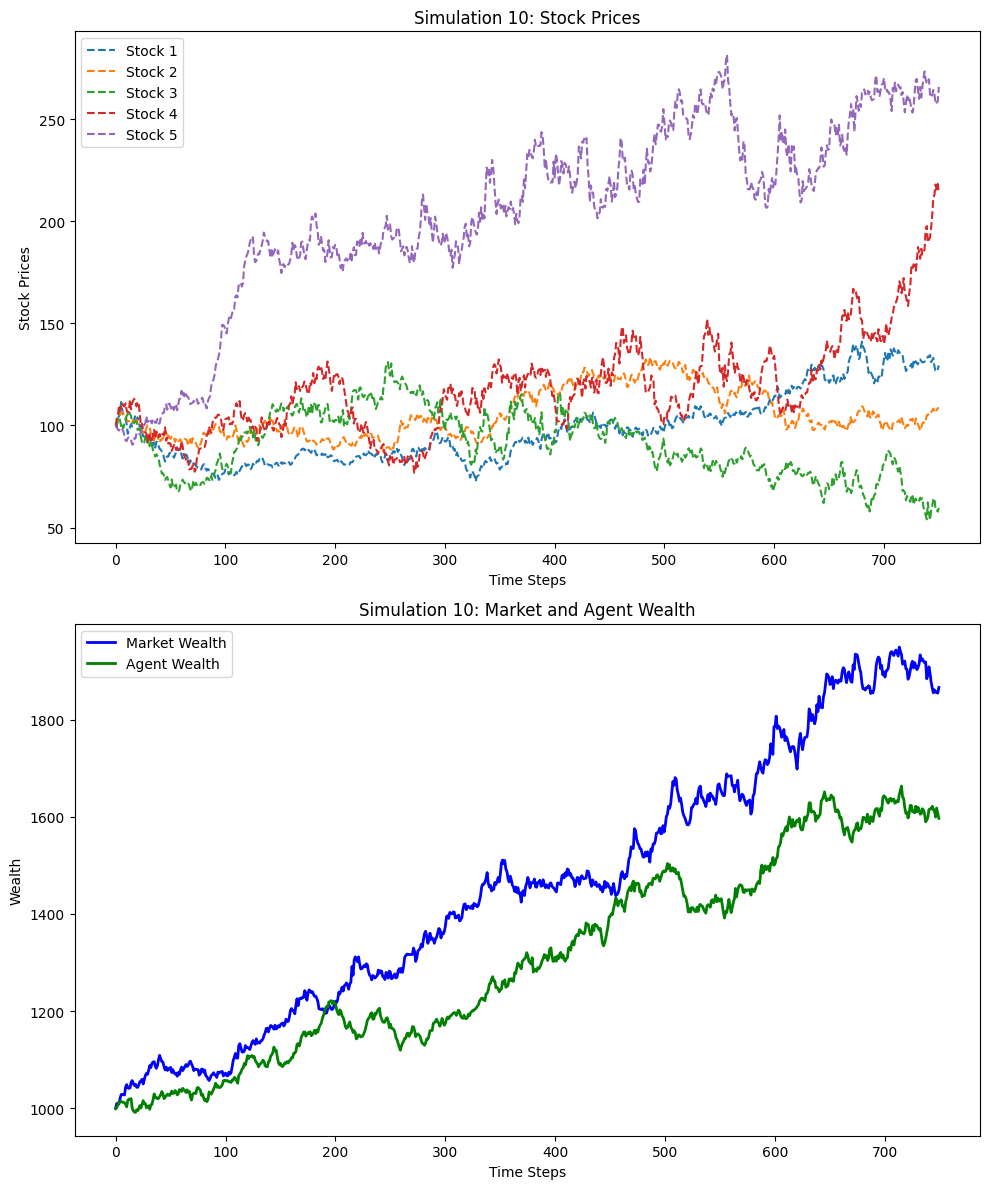

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Function to plot the stock prices, agent wealth, and market wealth for a specific simulation
def plot_simulation(simulation_index, surplus, markets, agents, stock_data_dict):
    # Extract data for the specific simulation
    market_wealth = np.mean(markets[:2], axis=0)
    agent_wealth = np.mean(agents[:2], axis=0)

    prices_list = []

    for i in range(3):
        stock_prices = gd.get_combined_simulation(stock_data_dict, simulation_index=simulation_index, set_type='test')
        prices_list.append(stock_prices)
    
    stock_prices = np.mean(prices_list, axis=0)


    # market_wealth = markets[simulation_index]
    # agent_wealth = agents[simulation_index]
    # stock_prices = gd.get_combined_simulation(stock_data_dict, simulation_index=simulation_index, set_type='test')

    # Create a figure with two subplots (one for stock prices, one for market and agent wealth)
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot stock prices in the first subplot
    for i in range(stock_prices.shape[1]):  # Loop through each stock
        axs[0].plot(stock_prices[:, i], label=f'Stock {i+1}', linestyle='--')
    axs[0].set_title(f"Simulation {simulation_index}: Stock Prices")
    axs[0].set_xlabel("Time Steps")
    axs[0].set_ylabel("Stock Prices")
    axs[0].legend()

    # Plot market and agent wealth in the second subplot
    axs[1].plot(market_wealth, label='Market Wealth', color='blue', linewidth=2)
    axs[1].plot(agent_wealth, label='Agent Wealth', color='green', linewidth=2)
    axs[1].set_title(f"Simulation {simulation_index}: Market and Agent Wealth")
    axs[1].set_xlabel("Time Steps")
    axs[1].set_ylabel("Wealth")
    axs[1].legend()

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# Assuming the `stock_data_dict` was loaded as in your code, pass a specific simulation index
simulation_index = 10  # Change this to the index you want to visualize
plot_simulation(simulation_index, surplus, markets, agents, stock_data_dict)


# DSR

In [10]:
def calculate_A_B(returns, eta, tolerance=1e-6):
    # Initialize A and B to 0
    A, B = 0.0, 0.0
    A_values = [A]  # Initial A value
    B_values = [B]  # Initial B value
    match_results = []  # To store comparison results

    # Iterate through each return in the list
    for R in returns:
        # Check if B is approximately equal to A squared
        is_match = abs(B - A**2) < tolerance
        print(abs(B - A**2))
        match_results.append(is_match)

        # Update A and B based on the formulas
        delta_A = eta * (R - A)
        delta_B = eta * (R**2 - B)
        
        A += delta_A
        B += delta_B

        # Store the results for each time step
        A_values.append(A)
        B_values.append(B)
        

    
    return A_values, B_values, match_results

# Input list of returns R and learning rate eta
returns = [0.05, 0.05, 0.05, 0.01, 0.03]  # example list of returns
eta = 0.1  # example learning rate

# Calculate A and B
A_values, B_values, match_results = calculate_A_B(returns, eta)

# Display the results
print("A values:", A_values)
print("B values:", B_values)
print("Is B approximately A^2 at each step?", match_results)


0.0
0.00022500000000000005
0.0003847500000000001
0.0004938975
0.0004456419750000001
A values: [0.0, 0.005000000000000001, 0.009500000000000001, 0.013550000000000003, 0.013195000000000002, 0.014875500000000002]
B values: [0.0, 0.00025000000000000006, 0.0004750000000000001, 0.0006775000000000002, 0.0006197500000000002, 0.0006477750000000002]
Is B approximately A^2 at each step? [True, False, False, False, False]
